In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tf_mcc import MCC

In [42]:
# load training and validation sets

X_train = pd.read_csv("dataset/X_train.csv")
X_val = pd.read_csv("dataset/X_val.csv")
y_train = pd.read_csv("dataset/y_train.csv")
y_val = pd.read_csv("dataset/y_val.csv")

In [45]:
X_train = X_train['title'].values
X_val = X_val['title'].values

y_train = y_train['classification'].values
y_val = y_val['classification'].values

In [49]:
# model parameters
vocabulary_size = 10000 # maximum vocabulary size (max_features, maximum number of tokens)
max_len = 250 # sequence length to pad the outputs to
embedding_dim = 16

# create vocab layer
# instantiate the text vectorization layer
vectorize_layer = TextVectorization(max_tokens = vocabulary_size, 
                                    standardize = "lower_and_strip_punctuation", 
                                    output_mode = "int", 
                                    output_sequence_length = max_len)

# build the vocabulary
# vectorization layer that generates a tensor of shape (batch_size, max_len) containing vocabulary indices
vectorize_layer.adapt(X_train)

# vectorize_layer.get_vocabulary()
# vectorize_layer.vocabulary_size()

In [50]:
train_text = vectorize_layer(X_train)
val_text = vectorize_layer(X_val)
# test_text = vectorize_layer(X_test)

In [51]:
train_text.shape

TensorShape([26562, 250])

In [52]:
model = Sequential([
    tf.keras.Input(shape = (250,), dtype = tf.int64),
    layers.Embedding(vocabulary_size + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units = 1, activation = "sigmoid") # revise the use of this layer
]
)

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 16)           160016    
                                                                 
 dropout (Dropout)           (None, 250, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [54]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = [
                  tf.keras.metrics.BinaryAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  MCC(),
              ],
)


callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)


history = model.fit(
        train_text, y_train,
        validation_data = (val_text, y_val),
        epochs = 20,
        callbacks = [callback],
)

Epoch 1/20
831/831 [==============================] - 5s 4ms/step - loss: 0.6768 - binary_accuracy: 0.6352 - precision: 0.7504 - recall: 0.3628 - mcc: 0.2965 - val_loss: 0.6437 - val_binary_accuracy: 0.9083 - val_precision: 0.9078 - val_recall: 0.9062 - val_mcc: 0.8165
Epoch 2/20
831/831 [==============================] - 3s 4ms/step - loss: 0.5837 - binary_accuracy: 0.8844 - precision: 0.8932 - recall: 0.8630 - mcc: 0.7686 - val_loss: 0.5094 - val_binary_accuracy: 0.9128 - val_precision: 0.9155 - val_recall: 0.9071 - val_mcc: 0.8256
Epoch 3/20
831/831 [==============================] - 3s 4ms/step - loss: 0.4481 - binary_accuracy: 0.9131 - precision: 0.8955 - recall: 0.9279 - mcc: 0.8268 - val_loss: 0.3843 - val_binary_accuracy: 0.9177 - val_precision: 0.9198 - val_recall: 0.9128 - val_mcc: 0.8353
Epoch 4/20
831/831 [==============================] - 3s 4ms/step - loss: 0.3431 - binary_accuracy: 0.9230 - precision: 0.9039 - recall: 0.9399 - mcc: 0.8466 - val_loss: 0.3007 - val_binary_

In [55]:
history.history

{'loss': [0.67681884765625,
  0.58368980884552,
  0.44809138774871826,
  0.3430671691894531,
  0.2751770615577698,
  0.22967879474163055,
  0.19691720604896545,
  0.1735343188047409,
  0.15646997094154358,
  0.1414453238248825,
  0.12955768406391144,
  0.12012001127004623,
  0.11108221113681793,
  0.10524458438158035,
  0.0986926332116127,
  0.0936179906129837,
  0.08883997052907944,
  0.0843600183725357,
  0.08009739965200424,
  0.07686765491962433],
 'binary_accuracy': [0.6351931095123291,
  0.8843836784362793,
  0.9131466150283813,
  0.9229726791381836,
  0.9302763342857361,
  0.9375799894332886,
  0.944055438041687,
  0.9475190043449402,
  0.9510579109191895,
  0.9547473788261414,
  0.9584745168685913,
  0.9600933790206909,
  0.962691068649292,
  0.9643852114677429,
  0.9660040736198425,
  0.9678111672401428,
  0.9697688221931458,
  0.971011221408844,
  0.9727053642272949,
  0.9737595319747925],
 'precision': [0.7503640055656433,
  0.8932156562805176,
  0.8954558968544006,
  0.9039

In [56]:
epochs = history.epoch

In [57]:
range(1, max(history.epoch) + 2)

range(1, 21)

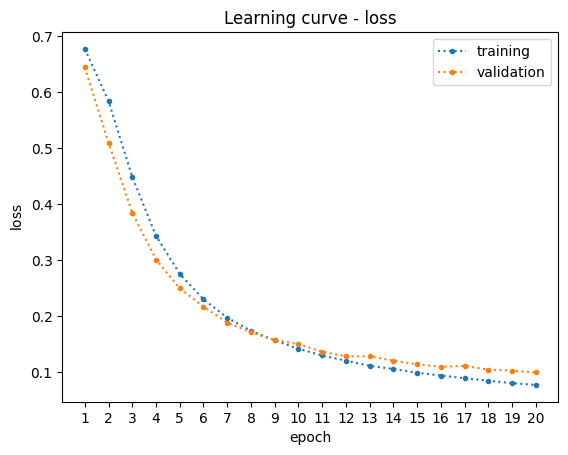

In [58]:
plt.plot(range(1, max(epochs) + 2), history.history['loss'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_loss'], ".:")

plt.title('Learning curve - loss')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel(r"$\mathrm{loss}$")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

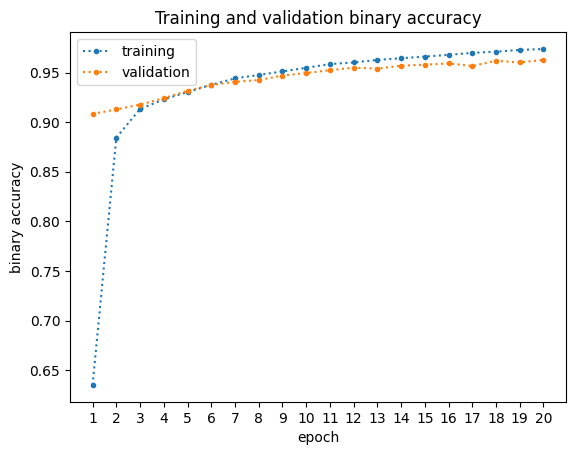

In [59]:
plt.plot(range(1, max(epochs) + 2), history.history['binary_accuracy'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_binary_accuracy'], ".:")

plt.title('Training and validation binary accuracy')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("binary accuracy")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

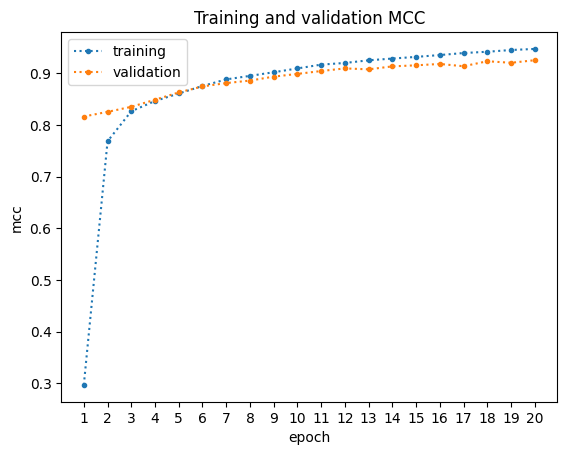

In [60]:
plt.plot(range(1, max(epochs) + 2), history.history['mcc'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_mcc'], ".:")

plt.title('Training and validation MCC')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("mcc")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()